#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [2]:
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [3]:
d, Nobs = 20, 50
pX = 1e-1
pξ = 1e-1
X = rand(Normal(), d, Nobs) .* rand(Binomial(1,pX), d, Nobs)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,pξ), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = copy(d)
σ02 = 1

# prior = HS_prior(d, σ02) 
prior = GDP_prior(d, σ02)
# prior = gaussian_prior_nh(zeros(d), 10*rand(d))

GDP_prior(20, 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0, 1.0, 1.0, 1.0, 1.0)

In [4]:
sum(y)

25.0

In [5]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [19]:
# Sub-Sampling with control variate and with weights
ϵ = 1e-2
weights_cv = zeros(d, Nobs)
for n in 1:Nobs
    weights_cv[:,n] = [abs.(X[i,n])*norm(X[:,n]) for i in 1:d] + ϵ
end
weights_cv ./= sum(weights_cv,2);
gs = [wumbsampler(Nobs, mb_size, weights_cv[i,:]) for i in 1:d];
gs_list = cvmbsampler_list(my_model, gs, root);

In [20]:
A = eye(d)

opf = projopf(A, 100, hyperparam_size(prior))
opt = maxa_opt(10^5)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [21]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [22]:
adapt_speed = true
L = 2
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [23]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.03 mins 
20% attempts in 0.06 mins 
30% attempts in 0.08 mins 
40% attempts in 0.11 mins 
50% attempts in 0.14 mins 
60% attempts in 0.17 mins 
70% attempts in 0.2 mins 
80% attempts in 0.23 mins 
90% attempts in 0.25 mins 
100% attempts in 0.28 mins 
0.28 mins

In [24]:
print(size(outp.opf.alpha_skeleton), " ", size(outp.opf.xi_skeleton))

(20, 16825) (20, 16825)

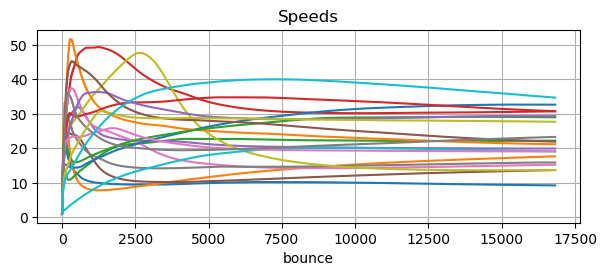

In [25]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
# ylim(0,4000)
grid(true)

In [38]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

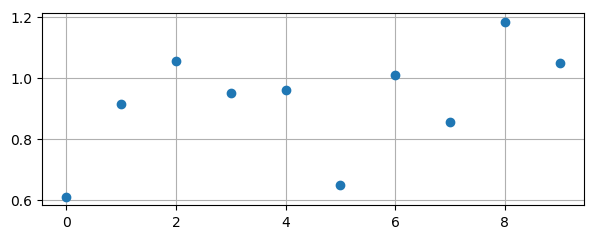

In [39]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)

In [40]:
xi_samples

10×10001 Array{Float64,2}:
 0.0  0.00742184  0.0148437  0.0222655  0.0296874  …  -1.36182     -1.36924  
 0.0  0.00742184  0.0148437  0.0222655  0.0296874      0.00751634   0.0149382
 0.0  0.00742184  0.0148437  0.0222655  0.0296874      0.463926     0.456505 
 0.0  0.00742184  0.0148437  0.0222655  0.0296874      0.140602     0.133181 
 0.0  0.00742184  0.0148437  0.0222655  0.0296874     -0.073688    -0.0811098
 0.0  0.00742184  0.0148437  0.0222655  0.0296874  …   2.20995      2.20253  
 0.0  0.00742184  0.0148437  0.0222655  0.0296874      0.111192     0.118613 
 0.0  0.00742184  0.0148437  0.0222655  0.0296874      0.0076099    0.0075601
 0.0  0.00742184  0.0148437  0.0222655  0.0296874     -0.131855    -0.139277 
 0.0  0.00742184  0.0148437  0.0222655  0.0296874      0.390122     0.397544 

In [44]:
mean(xi_samples, 2)

10×1 Array{Float64,2}:
 -1.38111   
 -0.0856944 
 -0.091039  
  0.110725  
  0.0978729 
  0.953683  
 -0.00932719
  0.0167755 
  0.0249637 
  0.332635  

In [46]:
ξ_true

10-element Array{Float64,1}:
 -1.62195 
  0.0     
 -0.0     
  0.452379
 -0.734745
 -0.0     
  0.0     
 -0.0     
  0.309186
  1.64292 

In [54]:
for i in 1:d 
    ci = percentile(xi_samples[i,:], [5, 95])
    print((ci[1]<ξ_true[i])&(ξ_true[i]<ci[2]), "\n")
end

true
true
true
true
false
true
true
true
true
false


In [24]:
get_event_time

get_event_time (generic function with 3 methods)